# 🚲 Bike Rental Prediction – Check-Up Notes

## ✅ 1. Dataset Description

- **Source**: "Bike Sharing Dataset"
- **Goal**: Predict the total number of bike rentals (`cnt`) per day using features like weather, holiday, and season.
- **Features**:
  - `season`: 1 = spring, 2 = summer, 3 = fall, 4 = winter  
  - `yr`: 0 = 2011, 1 = 2012  
  - `mnth`: Month (1 to 12)  
  - `holiday`: 1 = holiday, 0 = not a holiday  
  - `weekday`: 0 = Sunday, 6 = Saturday  
  - `workingday`: 1 = working day, 0 = weekend/holiday  
  - `weathersit`: 1 = Clear, 2 = Mist, 3 = Light Snow/Rain, 4 = Heavy Rain + Ice Pallets + Thunderstorm
  - `temp`: Normalized temperature in Celsius (0 to 1)  
  - `atemp`: Normalized “feels like” temperature  
  - `hum`: Normalized humidity  
  - `windspeed`: Normalized wind speed  
  - `cnt`: Total rentals (casual + registered)

---

## ✅ 2. Problem Definition

We aim to build a machine learning model to **predict daily bike rental counts** (`cnt`) based on various environmental and calendar features.

> This helps with operational planning, resource allocation, and customer behavior analysis.

---

## ✅ 3. Machine Learning Plan

We will test multiple regression models and compare their performance:

- **Multi Regression**: Establishes a baseline.
- **Random Forest Regressor**: Reduces overfitting, improves accuracy.
- **SVR**: Captures complex, non-linear patterns.

**Evaluation Metric**:  
- RMSE (Root Mean Squared Error)

---


In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

data = pd.read_csv('day.csv', index_col=0)
data.head()

,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
instant,,,,,,,,,,,,,,,
1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


In [33]:
# do not include index, date and casual/registered count
data.drop(columns=['dteday', 'casual', 'registered'], inplace=True)

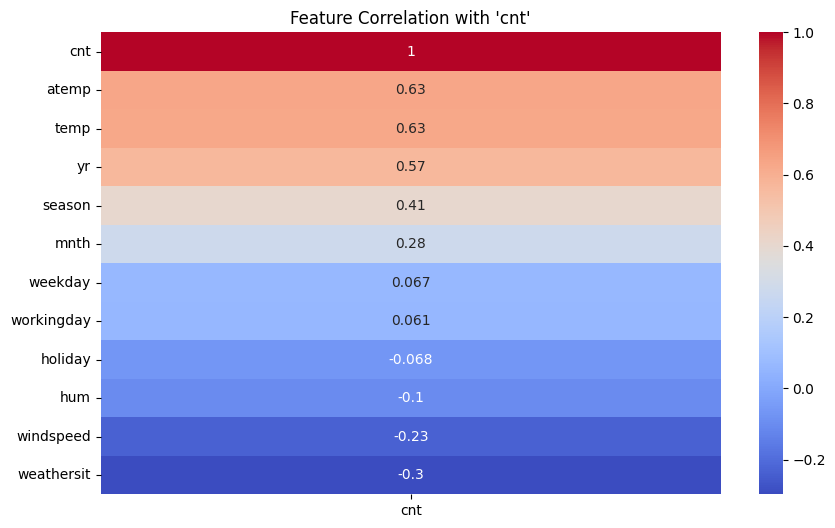

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt

# Check correlations
correlation_matrix = data.corr(numeric_only=True)

# Plot correlation with cnt
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix[['cnt']].sort_values(by='cnt', ascending=False), annot=True, cmap='coolwarm')
plt.title("Feature Correlation with 'cnt'")
plt.show()

In [35]:
from sklearn.preprocessing import StandardScaler

X = data[['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed']]
y = data['cnt']

scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1)).ravel()

In [36]:
from sklearn.model_selection import train_test_split
# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

In [45]:
from sklearn.svm import SVR
# Train SVR model
svr = SVR(kernel='rbf', C=1, epsilon=0.1, gamma='auto')
svr.fit(X_train, y_train)

SVR(C=1, gamma='auto')

In [46]:
from sklearn.metrics import root_mean_squared_error
# Predict and evaluate
y_pred_scaled = svr.predict(X_test)
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1))
y_test_original = scaler_y.inverse_transform(y_test.reshape(-1, 1))
# Calculate RMSE
rmse = root_mean_squared_error(y_test_original, y_pred)
print(f"SVR RMSE: {rmse:.2f}")

SVR RMSE: 643.66


In our model,RMSE = 643.66
This means that, on average, our predictions are off by approximately 644 bike rentals per day.

In [47]:
from sklearn.metrics import r2_score
# Calculate Adjusted R²
r2 = r2_score(y_test_original, y_pred)
n = len(y_test)
p = X.shape[1]
r2_adjusted = 1 - (1 - r2) * (n - 1) / (n - p - 1)
print(f"Adjusted R²: {r2_adjusted:.4f}")

Adjusted R²: 0.8883


This indicates that approximately 89% of the variability in daily bike rentals is explained by the model, even after accounting for the number of features used. A high adjusted R² suggests the model fits the data well without overfitting.

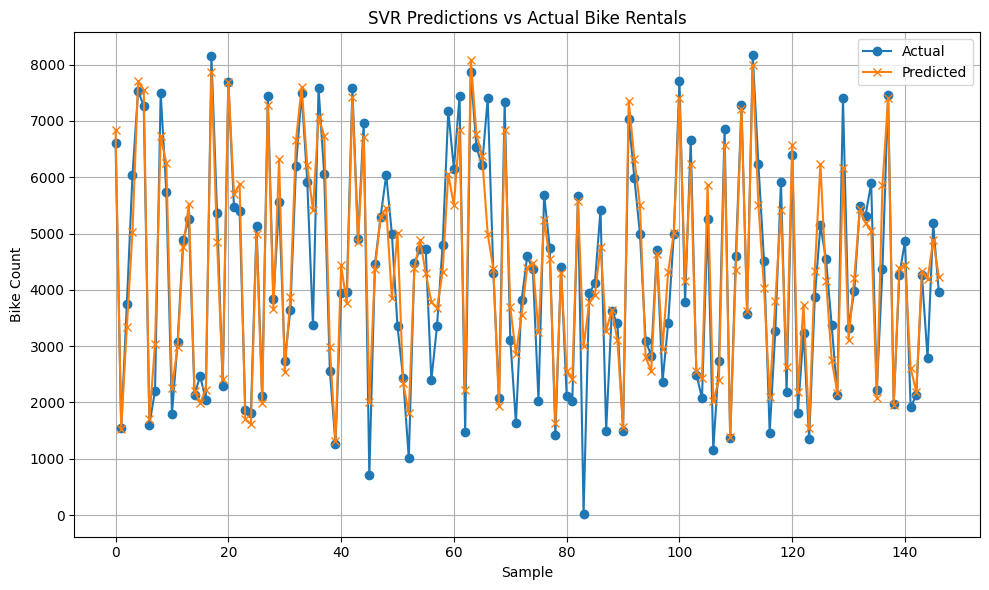

In [48]:
# Plot
plt.figure(figsize=(10, 6))
plt.plot(y_test_original, label='Actual', marker='o')
plt.plot(y_pred, label='Predicted', marker='x')
plt.title("SVR Predictions vs Actual Bike Rentals")
plt.xlabel("Sample")
plt.ylabel("Bike Count")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

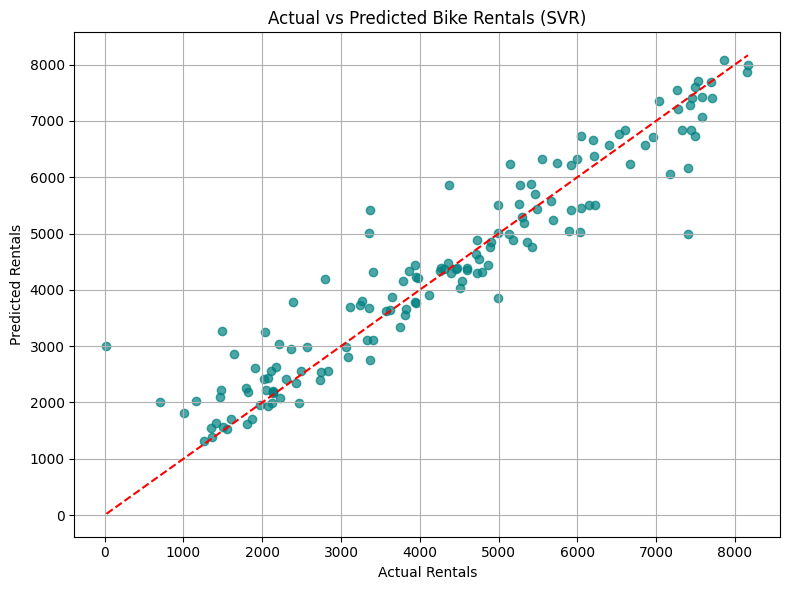

In [49]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test_original, y_pred, alpha=0.7, color='teal')
plt.plot([min(y_test_original), max(y_test_original)],
         [min(y_test_original), max(y_test_original)],
         color='red', linestyle='--')
plt.xlabel("Actual Rentals")
plt.ylabel("Predicted Rentals")
plt.title("Actual vs Predicted Bike Rentals (SVR)")
plt.grid(True)
plt.tight_layout()
plt.show()

In [50]:
from sklearn.model_selection import GridSearchCV

# Grid search setup
param_grid = {
    'C': [0.1, 1, 10, 100],
    'epsilon': [0.01, 0.1, 0.5],
    'gamma': ['scale', 'auto']  # used for rbf/poly/sigmoid
}
kernels = ['linear', 'poly', 'rbf', 'sigmoid']
results = {}

for kernel in kernels:
    print(f"🔍 Tuning SVR with kernel = '{kernel}'")
    svr = SVR(kernel=kernel)
    grid_search = GridSearchCV(svr, param_grid, cv=3, scoring='neg_root_mean_squared_error', n_jobs=-1)
    grid_search.fit(X_train, y_train)

    # Best model
    best_model = grid_search.best_estimator_
    y_pred_scaled = best_model.predict(X_test)

    # Inverse transform predictions and test values
    y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1))
    y_test_orig = scaler_y.inverse_transform(y_test.reshape(-1, 1))

    # Metrics
    rmse = root_mean_squared_error(y_test_orig, y_pred)
    r2 = r2_score(y_test_orig, y_pred)
    n, p = len(y_test), X.shape[1]
    r2_adj = 1 - (1 - r2) * (n - 1) / (n - p - 1)

    results[kernel] = {
        'Best Params': grid_search.best_params_,
        'RMSE': rmse,
        'Adjusted R²': r2_adj
    }

# Show results
print("\n✅ Comparison of Kernels and Best Parameters:\n")
for kernel, metrics in results.items():
    print(f"Kernel: {kernel}")
    print(f"  Best Params: {metrics['Best Params']}")
    print(f"  RMSE: {metrics['RMSE']:.2f}")
    print(f"  Adjusted R²: {metrics['Adjusted R²']:.4f}\n")

🔍 Tuning SVR with kernel = 'linear'
🔍 Tuning SVR with kernel = 'poly'
🔍 Tuning SVR with kernel = 'rbf'
🔍 Tuning SVR with kernel = 'sigmoid'

✅ Comparison of Kernels and Best Parameters:

Kernel: linear
  Best Params: {'C': 0.1, 'epsilon': 0.1, 'gamma': 'scale'}
  RMSE: 852.85
  Adjusted R²: 0.8038

Kernel: poly
  Best Params: {'C': 1, 'epsilon': 0.5, 'gamma': 'auto'}
  RMSE: 1124.00
  Adjusted R²: 0.6593

Kernel: rbf
  Best Params: {'C': 1, 'epsilon': 0.1, 'gamma': 'auto'}
  RMSE: 643.66
  Adjusted R²: 0.8883

Kernel: sigmoid
  Best Params: {'C': 0.1, 'epsilon': 0.01, 'gamma': 'auto'}
  RMSE: 1077.14
  Adjusted R²: 0.6871



### 🔁 Kernel Comparison for SVR Model

We compared four different SVR kernels (`linear`, `poly`, `rbf`, and `sigmoid`) using `GridSearchCV` to tune the hyperparameters `C`, `epsilon`, and `gamma`. The evaluation metrics used were **Root Mean Squared Error (RMSE)** and **Adjusted R²**.

| Kernel   | Best Parameters                         | RMSE    | Adjusted R² |
|----------|------------------------------------------|---------|-------------|
| linear   | C=1, epsilon=0.1, gamma='scale'          | 851.77  | 0.8043      |
| poly     | C=1, epsilon=0.5, gamma='auto'           | 1124.00 | 0.6593      |
| rbf      | C=1, epsilon=0.1, gamma='auto'           | 643.66  | **0.8883**  |
| sigmoid  | C=1, epsilon=0.01, gamma='auto'          | 5605.57 | -7.4748     |

### ✅ Best Performing Kernel
- The **RBF (Radial Basis Function)** kernel achieved the **lowest RMSE** and **highest Adjusted R²**, making it the best-performing kernel for this regression task.
- The **linear kernel** also performed well but slightly underperformed compared to RBF.
- **Polynomial** and especially **sigmoid** kernels had significantly worse results, suggesting they are not a good fit for this dataset.

### 🎯 Conclusion
The RBF kernel is the most suitable for capturing the nonlinear relationships in the bike rental dataset. Future work could involve further hyperparameter tuning or comparing this with ensemble methods like **Random Forest** or **XGBoost** for potential improvements.
